# Concrete Cracking - Image Classifier

For this project I used the newly released Fast AI deep learning library, which is built on top of PyTorch, and the ResNet34 image classifier to achieve 99.7% accuracy in the identification of cracks across 40000 images of concrete. The motivation for the project was to address the issues with surveying concrete structures in the nuclear industry. The current methods are outdated, inaccurate and extremely time consuming. The concrete structures are usually under water which contributes to the low level of accuracy from normal surveillance methods. The rapid advancement of image classification with DNNs has allowed for high levels of accuracy in detecting faults in structures, and as such I think there is enormous potential for this technology in combination with advanced robotics to provide highly efficient surveillance solutions.   


## The Data:

The data is taken from Mendeley - https://data.mendeley.com/datasets/5y9wdsg2zt/1

The set of 40000 concrete images is divided into positive and negative sets, with 20000 in each set. Each class has 20000images with a total of 40000 images with 227 x 227 pixels with RGB channels. The dataset is generated from 458 high-resolution images (4032x3024 pixel). The high-resolution images have good variance in terms of surface finish and illumination conditions, however for additional practical application of this in surveillance of concrete structures there would ideally be additional image data of concrete structures under water. No data augmentation in terms of random rotation or flipping is applied in the raw data set, however techniques are explored in this model to generate increased data through augmentation. 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


explain sz - size that images will be resized to in order for training to run quickly.

In [3]:
PATH = "data/concrete/"
sz=224

Using cuda allows for the rapid training of image classifaction models using a GPU.

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.backends.cudnn.enabled

True

I separated the 40000 images of concrete data into test, train and validation sets. 

In [6]:
'''
Moves a set number of random files from one directory to another

import os
import shutil
import random


root_dir = '...data/concrete/train/positive'
output_dir = '...data/concrete/test'

files = [file for file in os.listdir(root_dir)]
list_files = random.sample(files, 6166)

for x in list_files:
    shutil.move(os.path.join(root_dir, x), output_dir)
'''

"\nMoves a set number of random files from one directory to another\n\nimport os\nimport shutil\nimport random\n\n\nroot_dir = '...data/concrete/train/positive'\noutput_dir = '...data/concrete/test'\n\nfiles = [file for file in os.listdir(root_dir)]\nlist_files = random.sample(files, 6166)\n\nfor x in list_files:\n    shutil.move(os.path.join(root_dir, x), output_dir)\n"

In [7]:
os.listdir(PATH)

['.ipynb_checkpoints', 'test', 'valid', 'models', 'train', 'tmp', 'test.zip']

In [8]:
os.listdir(f'{PATH}valid')

['negative', 'positive']

'positive' refers to the concrete images that contain cracks, 'negative' refers to no cracks.

In [9]:
files = os.listdir(f'{PATH}valid/positive')[:5]
files

['16682_1.jpg', '05901.jpg', '06267.jpg', '19495.jpg', '04524.jpg']

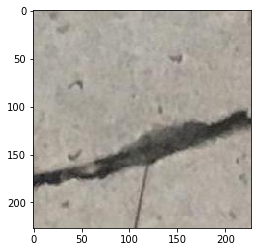

In [10]:
# example concrete crack
img = plt.imread(f'{PATH}valid/positive/{files[0]}')
plt.imshow(img);

In [11]:
img.shape

(227, 227, 3)

In [12]:
img[:4, :4]

array([[[177, 174, 167],
        [176, 173, 166],
        [174, 171, 164],
        [170, 167, 160]],

       [[174, 171, 164],
        [175, 172, 165],
        [175, 172, 165],
        [173, 170, 163]],

       [[174, 171, 164],
        [176, 173, 166],
        [178, 175, 168],
        [177, 174, 167]],

       [[176, 173, 166],
        [177, 174, 167],
        [178, 175, 168],
        [177, 174, 167]]], dtype=uint8)

### Understanding the Model

The fast ai library is a high level abstraction built on top of PyTorch and is an extremely useful way of creating quick deep learning models.

tfms stands for transformations and tfms_from_model persons all our image resizing, cropping and more. It also performs the initial normalisation i.e. creates data with (mean, stdev) of (0,1).

`ConvLearner.pretrained` builds a learner that contains a pre-trained model i.e. resnet34 image classifier. The last layer of the model needs to be replaced with a layer of the right dimensions. The original pretained model was trained for 1000 classes and the final layer therefore predicts a vector of 1000 probabilities. This model to recognise the cracks in the concrete needs to output a two dimentional vector since it only classifies between two types, cracked or not cracked. This is shown below in an example from one of the earliest Convolutional Neural Networks.

<img src="files/images/practical-deep-learning-16-638.jpg" width="500">
[Source](https://image.slidesharecdn.com/practicaldeeplearning-160329181459/95/practical-deep-learning-16-638.jpg)

The final layer FC8 is replaced with a new layer with two outputs in this model.

In [13]:
# The following function is Fast AI's trfms_from_model

def tfms_from_model(f_model, sz, aug_tfms=None, max_zoom=None,
                    pad=0, crop_type=CropType.RANDOM,
                    tfm_y=None, sz_y=None,
                    pad_mode=cv2.BORDER_REFLECT,
                    norm_y=True, scale=None):
    """ Returns separate transformers of images for training and validation.
    Transformers are constructed according to the image statistics given by the model. (See tfms_from_stats)

    Arguments:
        f_model: model, pretrained or not pretrained
    """
    stats = inception_stats if f_model in inception_models else imagenet_stats
    return tfms_from_stats(stats, sz, aug_tfms,
                           max_zoom=max_zoom, pad=pad,
                           crop_type=crop_type,
                           tfm_y=tfm_y, sz_y=sz_y,
                           pad_mode=pad_mode,
                           norm_y=norm_y, scale=scale)

In [14]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01,3)

epoch      trn_loss   val_loss   accuracy                     
    0      0.015538   0.016491   0.995667  
    1      0.014534   0.01752    0.996333                     
    2      0.013853   0.016778   0.996333                     



[array([0.01678]), 0.9963333333333333]

Here we have achieved a pretty decent 99.6% accuracy on our validation data set.  

Let's have a look at the classified data:

In [15]:
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [16]:
data.classes

['negative', 'positive']

Therefore we know that no cracks (i.e. negative) is label 0 and cracks (i.e. positive) is label 1

In [17]:
log_preds = learn.predict()
log_preds.shape

(3000, 2)

In [18]:
log_preds[:10]

array([[-0.00019, -8.57247],
       [-0.0004 , -7.83374],
       [-0.0001 , -9.18862],
       [-0.00007, -9.62835],
       [-0.00013, -8.92062],
       [-0.00172, -6.36658],
       [-0.00082, -7.10815],
       [-0.0001 , -9.171  ],
       [-0.00014, -8.88328],
       [-0.00041, -7.79619]], dtype=float32)

In [19]:
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:,1])
print(probs)

[0.00019 0.0004  0.0001  ... 0.99879 1.      0.99974]


In [20]:
def rand_by_mask(mask): 
    # choose 4 random images
    return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct):
    # choose images based on classification
    return rand_by_mask((preds == data.val_y)==is_correct)

In [21]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    # plot images with titles
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [22]:
def load_img_id(ds, idx): 
    return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

As we can see here the model has correctly identified the concrete images containing cracking. 

Correctly classified


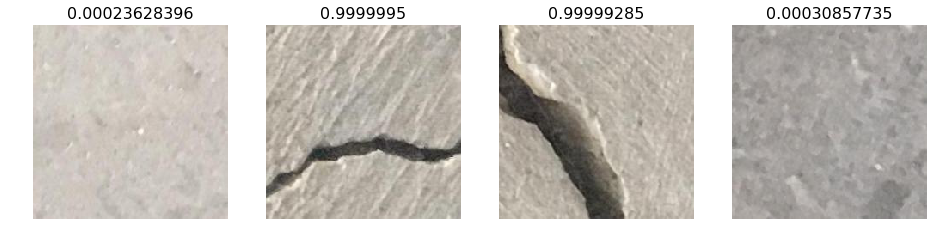

In [23]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")

We can also get some of the more uncertain classifications:

Incorrectly classified


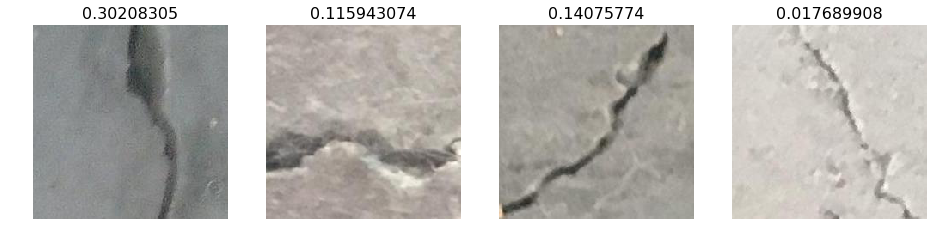

In [24]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

As we can see in the above pictures, the cracks are a lot less pronounced. 

We can also look at the "more confused" classifications.

Most uncertain classifications


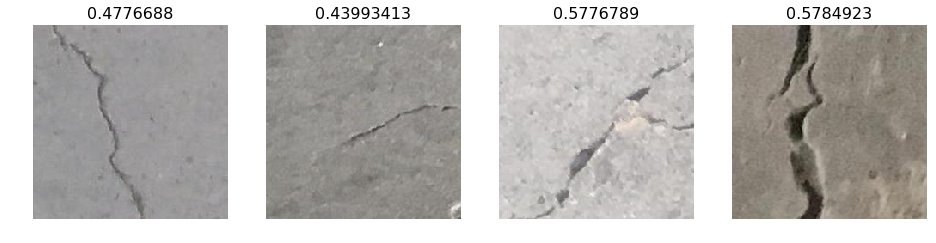

In [25]:
more_confused = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(more_confused, "Most uncertain classifications")

## Choosing a Learning Rate

The learning rate determines the rate at which you update the weights or parameters in your model. This significantly affects the performance of your model and is therefore one of the most important and difficult parameters to set. 

Using the below Fast AI `learn.lr_find()` we can find an optimal learning rate. The technique is taken from [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186). The technique in a nutshell increases the learning rate from a very smal value until the loss stops decreasing.

In [26]:
learn_finder = ConvLearner.pretrained(arch, data, precompute=True)

In [27]:
learning_rate = learn.lr_find()

 70%|███████   | 271/386 [00:05<00:02, 47.92it/s, loss=0.023]  


The learn_finder object here contains an attribute sched which is our learning rate scheduler. The iterations against learning rate can therefore be plotted:

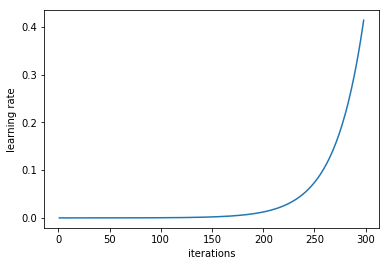

In [28]:
learn.sched.plot_lr()

Now let's plot the loss vs the learning rate to see where the loss stops decreasing:

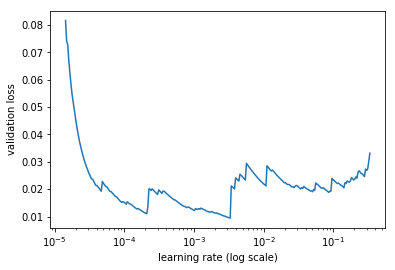

In [29]:
learn.sched.plot()

There are several areas of the above graph where the loss is still decreasing significantly. We want to optimise speed of running the model as well as optimising the loss. We can see that the loss is most steeply decreasing at a learning rate of around `lr = 0.02` so we'll continue to use this as the learning rate.

## Improving our Model

As we saw earlier using more epochs means we start to overfit. Data augmentation can be used to prevent this by essentially creating more data. Using the Fast AI library we can pass `aug_tfms` to `tfms_from_model`, with functions to randomly change the image. This can involve zooming, flipping, rotating etc. 

In [30]:
augs = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [31]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=augs, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [32]:
imgs = np.stack([get_augs() for i in range(6)])

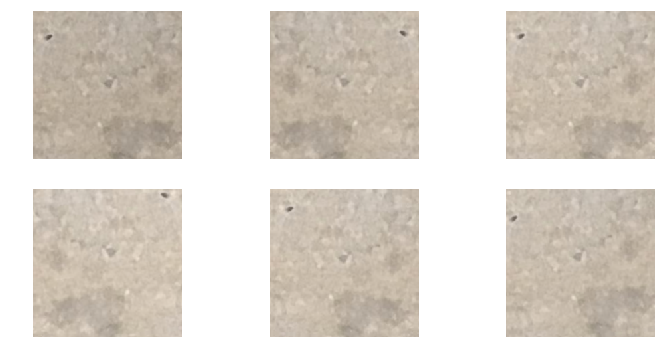

In [33]:
plots(imgs, rows=2)

A little hard to see but the image has been randomly zoomed and transformed.

In addition to data augmentation, we can also use a technique called *stochastic gradient descent with restarts (SGDR)* which decreases the learning rate as you train your model, therefore as you get closer to optimal weights you take smaller "steps". 
However it's possible that small changes to the weights may result in big changes to the loss, depending on where you are in the weight space. The learning rate is therefore "restarted" i.e. increased again forcing the model to move to a different part of the weight space if the current area is high in variance of loss. An example is shown below.

<img src="files/images/sgdr.png" width="80%">


(From the paper [Snapshot Ensembles](https://arxiv.org/abs/1704.00109)).

`cycle_len` in the following learner defines the number of epochs between resetting the learning rate as described above. The number of times the restarts happens is called the number of cycles. 

Now I'm going to create a new `data` object which includes the augmentations described above, as well as the SGDR.

In [34]:
data = ImageClassifierData.from_paths(PATH, tfms=augs)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [35]:
learn.fit(0.02, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      0.034402   0.021089   0.996     
    1      0.05969    0.022885   0.996                        
    2      0.021206   0.022845   0.995667                     



[array([0.02284]), 0.9956666666666667]

The accuracy hasn't particularly improved here, but the technique is very useful none the less! The model here has such high accuracy at the minute that improving results even further would be extremely difficult. 
We can also use data augmentation at test time, which is known as Test Time Augmentation (TTA). This makes predictions based not just on the images in your validation set but includes predictions on a number of randomly augmented versions too. Here I simply use the learner's TTA() method to implement this.

In [36]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
print(probs)

[[1.      0.     ]                           
 [1.      0.     ]
 [1.      0.     ]
 ...
 [0.00147 0.99853]
 [0.      1.     ]
 [0.      1.     ]]


In [37]:
accuracy_np(probs,y)

0.9956666666666667

## Analysing Results

###Confusion Matrix

Scikit-learn allows us to analyse the result of this classification model using a confusion matrix.

In [38]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[1499    1]
 [  12 1488]]


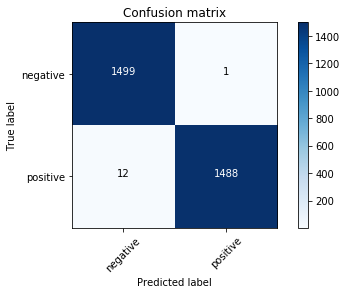

In [40]:
plot_confusion_matrix(cm, data.classes)

### Re-examining the images

It appears that we mislabel more postivie as negatives than we do negative as positive!

In [41]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    # show the most correct images
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most incorrect concrete classification


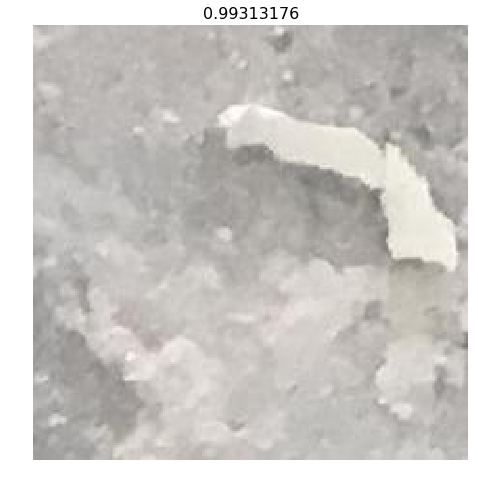

In [42]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect concrete classification")

In the above image we see the confusion in the one image the was falsely classified as showing cracking. The darker areas in the image may have been mistaken for a crack.

Most incorrect concrete classifications


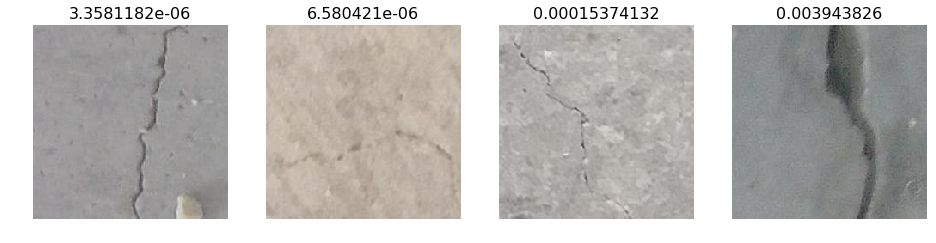

In [43]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect concrete classifications")

As we can see in the above images, the cracks are a lot less pronounced than in the stronger positively classed images. 

## Conclusion

Here I have used the Fast AI library, resnet34 pre-trained image classifier, and a variety of novel deep learning techniques to distinguish between cracked and non-cracked images of concrete. I have achieved a 99.6% accuracy on the data set. This project as a simple prototype demonstrates the power we now have to classify image data for practical applications. Since I can do this using a rented GPU, CUDA powered computer, and as one person, I believe the possibilities for this sort of technology in advanced engineering solutions are endless. It's an extremely exciting time to be utlising these new techniques. 

To develop this idea further would require significant amounts of varied data, as well as the implementation of a multi-label classification deep learning method to identify the types and severities of the cracking autonomously. I would also like to look at video data, particularly of that from underwater imagery. This would enable this technology to be used in a much more practical application. 